# Notebook to forecast quantiles for the DAX

# Imports

In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
import yfinance as yf
from datetime import datetime
import requests
import json
import sys
import math
import matplotlib.pyplot as plt

from prophet import Prophet

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

import arch
from arch import arch_model

#from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
#from darts.utils.likelihood_models import GaussianLikelihood
#from darts.timeseries import TimeSeries

pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', sys.maxsize)

# Functions

In [3]:
def quantile_loss(y_true, y_pred, quantile):
    
    if y_true > y_pred:
        loss = quantile * (y_true - y_pred)
    else:
        loss = (1 - quantile) * (y_pred - y_true)
    return loss


In [ ]:
def energy_eval(energydata):
    energytraindata = energydata[:-6]
    energytestdata = energydata[-6:]

    energyforecast = energy_model(energytraindata)
    energyforecast = pd.DataFrame(energyforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

    energyevaldata = energytestdata.copy(deep=True)
    energyevaldata["q0.025"] = np.array(energyforecast["q0.025"])
    energyevaldata["q0.25"] = np.array(energyforecast["q0.25"])
    energyevaldata["q0.5"] = np.array(energyforecast["q0.5"])
    energyevaldata["q0.75"] = np.array(energyforecast["q0.75"])
    energyevaldata["q0.975"] = np.array(energyforecast["q0.975"])

    energyevaldata.data = energyevaldata.data / 1000

    energyevaldata.plot()

    totalloss = 0
    for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
        for i in range(len(energyevaldata)):
            totalloss += quantile_loss(energyevaldata["data"].iloc[i], energyevaldata[q].iloc[i], float(q[1:]))
    print("*********************************")
    print("Quantile Loss: " + str(totalloss))
    print("*********************************")
    

In [ ]:
def dax_eval(daxdata):
    daxtraindata = daxdata[:-5]
    daxtestdata = daxdata[-5:]

    daxforecast = dax_model(daxtraindata)
    daxforecast = pd.DataFrame(daxforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])
    daxevaldata = daxtestdata.copy(deep=True)

    daxevaldata["q0.025"] = np.array(daxforecast["q0.025"])
    daxevaldata["q0.25"] = np.array(daxforecast["q0.25"])
    daxevaldata["q0.5"] = np.array(daxforecast["q0.5"])
    daxevaldata["q0.75"] = np.array(daxforecast["q0.75"])
    daxevaldata["q0.975"] = np.array(daxforecast["q0.975"])
  
    daxevaldata.plot()

    totalloss = 0
    for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
        for i in range(len(daxevaldata)):
            totalloss += quantile_loss(daxevaldata["data"].iloc[i], daxevaldata[q].iloc[i], float(q[1:]))
    print("*********************************")
    print("Quantile Loss: " + str(totalloss))
    print("*********************************")


In [4]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

In [5]:
def create_submission_table():
    forecast_date = [str(datetime.now().date())] * 16
    target = ["DAX"] * 5 + ["energy"] * 6 + ["wind"] * 5
    horizon = ['1 day', '2 day', '5 day', '6 day', '7 day', '36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour', '36 hour', '48 hour', '60 hour', '72 hour', '84 hour']
    
    return pd.DataFrame({"forecast_date": forecast_date, "target": target, "horizon": horizon, "q0.025": [np.nan]*16, "q0.25": [np.nan]*16, "q0.5": [np.nan]*16, "q0.75": [np.nan]*16, "q0.975": [np.nan]*16})

In [6]:
def get_dax_data():
    msft = yf.Ticker("^GDAXI")
    hist = msft.history(period="max")
    data = hist[["Close"]]
    data = data.reset_index().rename(columns={"Date": "date_time"})
    data.set_index("date_time", inplace = True)
    data["data"] = compute_return(data.Close.values)
    data = data.dropna()
    data = data.drop(columns = "Close")
    #data = data.data.values
    
    return data

In [7]:
# Get energydata from csv
"""def get_energy_data():
    data = pd.read_csv("energy_data.csv", sep=";")
    data = data[data.columns[:3]]
    data = data.rename(columns={"Gesamt (Netzlast)[MWh]": "data"})
    data = data[data["data"] != "-"]
    data["date_time"] = pd.to_datetime(data['Datum'] + ' ' + data['Uhrzeit'], format = '%d.%m.%Y %H:%M')
    data = data.drop(columns = ["Datum", "Uhrzeit"])
    data = data.astype({"data": float})
    data.set_index("date_time", inplace=True)
    data = data.resample("1h", label = "left").sum()
    #data = data.data.values
    
    return data"""

'def get_energy_data():\n    data = pd.read_csv("energy_data.csv", sep=";")\n    data = data[data.columns[:3]]\n    data = data.rename(columns={"Gesamt (Netzlast)[MWh]": "data"})\n    data = data[data["data"] != "-"]\n    data["date_time"] = pd.to_datetime(data[\'Datum\'] + \' \' + data[\'Uhrzeit\'], format = \'%d.%m.%Y %H:%M\')\n    data = data.drop(columns = ["Datum", "Uhrzeit"])\n    data = data.astype({"data": float})\n    data.set_index("date_time", inplace=True)\n    data = data.resample("1h", label = "left").sum()\n    #data = data.data.values\n    \n    return data'

In [8]:
def get_energy_data(): 
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    timestamps = list(response.json()["timestamps"])

    energydata = pd.DataFrame(columns=["date_time", "data"])
    for stamp in timestamps[157:]:
        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]
        for i in range(len(rawdata)):
            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")
        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=["date_time", "data"])])
    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    energydata.set_index("date_time", inplace=True)
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [9]:
def create_submission_file(submission):
    submission.to_csv(datetime.now().strftime("%Y%m%d") + "_GreyWorm.csv", index = False)
    print("Submission file created")

# Current Models

In [10]:
def dax_model(daxdata):
    model = arch_model(daxdata, mean='Zero', vol='GARCH', p=15, q=15)
    model_fit = model.fit()
    yhat = model_fit.forecast(horizon=5)

    h1sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.1"].iloc[-1]), size=1000)
    h2sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.2"].iloc[-1]), size=1000)
    h3sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.3"].iloc[-1]), size=1000)
    h4sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.4"].iloc[-1]), size=1000)
    h5sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.5"].iloc[-1]), size=1000)

    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

    h1quantiles = np.quantile(h1sample, quantiles)
    h2quantiles = np.quantile(h2sample, quantiles)
    h3quantiles = np.quantile(h3sample, quantiles)
    h4quantiles = np.quantile(h4sample, quantiles)
    h5quantiles = np.quantile(h5sample, quantiles)
    daxquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles]

    return daxquantiles


In [11]:
def energy_model(energydata):
    energydata = energydata.loc[energydata.data != 0]
    
    enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
    enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
    enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

    ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
    ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
    ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

    dfs = [enf12, enf16, enf20, ens12, ens16, ens20]
    params = pd.DataFrame(columns = ["h1", "h2", "h3", "h4", "h5", "h6"])
    for i, df in enumerate(dfs):
        model = ARIMA(df.data, order=(3,1,2))
        model_fit = model.fit()
        fc = float(model_fit.forecast(1))
        params[params.columns[i]] = [fc, float(df[-8:].describe().loc["std"])]

    h1sample = np.random.normal(loc=float(params.iloc[0].h1), scale=float(params.iloc[1].h1), size=1000)
    h2sample = np.random.normal(loc=float(params.iloc[0].h2), scale=float(params.iloc[1].h2), size=1000)
    h3sample = np.random.normal(loc=float(params.iloc[0].h3), scale=float(params.iloc[1].h3), size=1000)
    h4sample = np.random.normal(loc=float(params.iloc[0].h4), scale=float(params.iloc[1].h4), size=1000)
    h5sample = np.random.normal(loc=float(params.iloc[0].h5), scale=float(params.iloc[1].h5), size=1000)
    h6sample = np.random.normal(loc=float(params.iloc[0].h6), scale=float(params.iloc[1].h6), size=1000)

    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

    h1quantiles = np.quantile(h1sample, quantiles)
    h2quantiles = np.quantile(h2sample, quantiles)
    h3quantiles = np.quantile(h3sample, quantiles)
    h4quantiles = np.quantile(h4sample, quantiles)
    h5quantiles = np.quantile(h5sample, quantiles)
    h6quantiles = np.quantile(h6sample, quantiles)

    energyquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles, h6quantiles]
    energyquantiles = [q/1000 for q in energyquantiles]

    return energyquantiles

# Modeling

## DAX

### GARCH

In [9]:
daxdata = get_dax_data()

In [10]:
model = arch_model(daxdata, mean='Zero', vol='GARCH', p=15, q=15)

In [11]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     33,   Neg. LLF: 21952.848165732248
Iteration:      2,   Func. Count:     69,   Neg. LLF: 1080714.516720877
Iteration:      3,   Func. Count:    102,   Neg. LLF: 17510.139643502614
Iteration:      4,   Func. Count:    135,   Neg. LLF: 17646.924419612402
Iteration:      5,   Func. Count:    169,   Neg. LLF: 19643.095636768227
Iteration:      6,   Func. Count:    202,   Neg. LLF: 15037.045303140727
Iteration:      7,   Func. Count:    235,   Neg. LLF: 15577.181014296973
Iteration:      8,   Func. Count:    268,   Neg. LLF: 33199.88432118808
Iteration:      9,   Func. Count:    301,   Neg. LLF: 16984.490653020104
Iteration:     10,   Func. Count:    334,   Neg. LLF: 20291.52154470017
Iteration:     11,   Func. Count:    368,   Neg. LLF: 16128.624358650488
Iteration:     12,   Func. Count:    402,   Neg. LLF: 15359.484813297753
Iteration:     13,   Func. Count:    435,   Neg. LLF: 14481.024073929828
Iteration:     14,   Func. Count:    469,   Neg. LLF: 

In [93]:
ret2 = daxdata.data**2

<AxesSubplot: xlabel='date_time'>

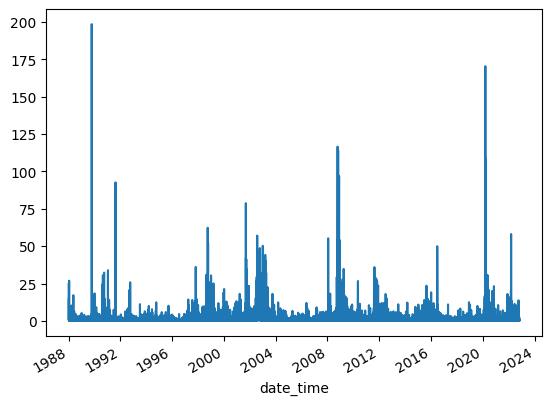

In [95]:
ret2.plot()

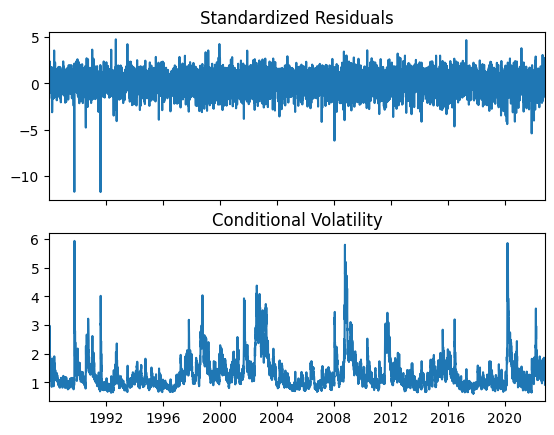

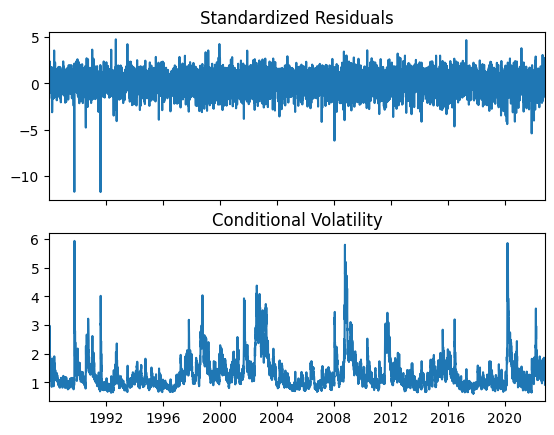

In [106]:
model_fit.plot()

In [12]:
yhat = model_fit.forecast(horizon=5)
yhat.variance.tail()

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


,h.1,h.2,h.3,h.4,h.5
date_time,,,,,
2022-11-03 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN
2022-11-04 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN
2022-11-07 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN
2022-11-08 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN
2022-11-09 00:00:00+01:00,1.391749,1.246107,1.284518,1.229189,1.537739


In [13]:
h1sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.1"].iloc[-1]), size=1000)
h2sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.2"].iloc[-1]), size=1000)
h3sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.3"].iloc[-1]), size=1000)
h4sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.4"].iloc[-1]), size=1000)
h5sample = np.random.normal(loc=0, scale=math.sqrt(yhat.variance["h.5"].iloc[-1]), size=1000)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

h1quantiles = np.quantile(h1sample, quantiles)
h2quantiles = np.quantile(h2sample, quantiles)
h3quantiles = np.quantile(h3sample, quantiles)
h4quantiles = np.quantile(h4sample, quantiles)
h5quantiles = np.quantile(h5sample, quantiles)
daxquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles]

## Energy

In [14]:
energydata = get_energy_data()

In [15]:
energydata = energydata.loc[energydata.data != 0]

<AxesSubplot: xlabel='date_time'>

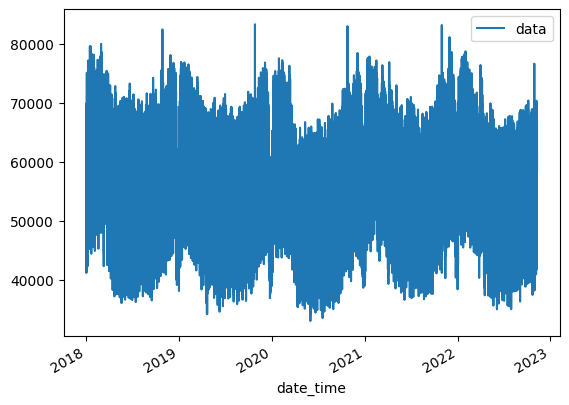

In [16]:
energydata.plot()

In [17]:
enf12 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 12)]
enf16 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 16)]
enf20 = energydata.loc[(energydata.index.dayofweek == 4) & (energydata.index.hour == 20)]

ens12 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 12)]
ens16 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 16)]
ens20 = energydata.loc[(energydata.index.dayofweek == 5) & (energydata.index.hour == 20)]

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


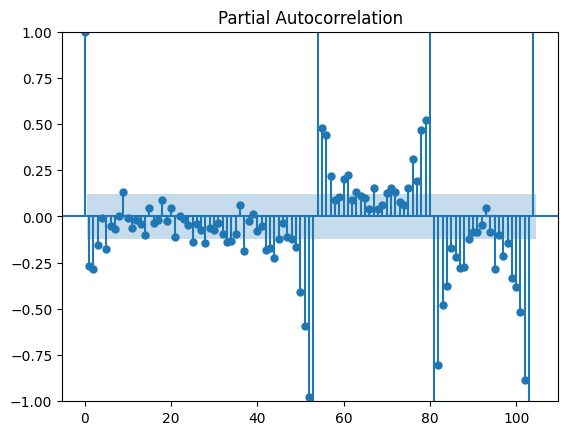

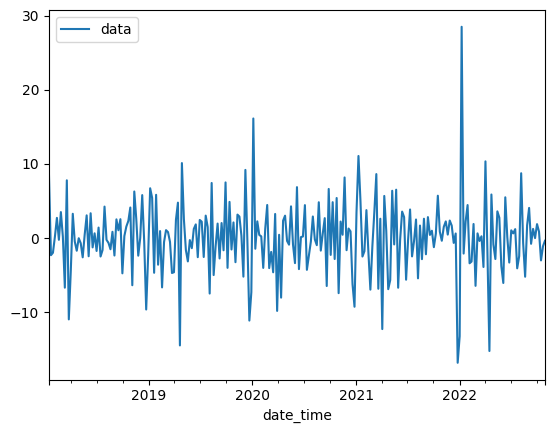

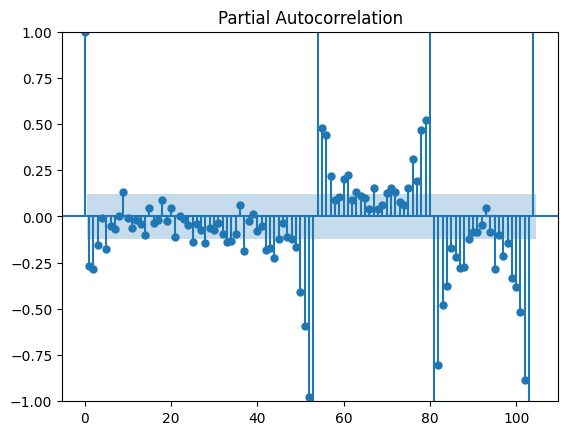

In [302]:
ts12 = ens12.copy()
ts12.data = compute_return(ens12.data.values)
ts12 = t12.dropna()
ts12.plot()
plot_pacf(ts12.data, lags=104)


In [381]:
model = ARIMA(ens12.data, order=(3,1,2))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  252
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2345.556
Date:                Sun, 06 Nov 2022   AIC                           4703.112
Time:                        01:34:13   BIC                           4724.264
Sample:                    01-06-2018   HQIC                          4711.624
                         - 10-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1119      0.123     -9.011      0.000      -1.354      -0.870
ar.L2         -0.9395      0.099     -9.535      0.000      -1.133      -0.746
ar.L3         -0.1108      0.028     -3.896      0.0

In [321]:
list(model_fit.params)[1:-1]

[-0.645380395526276,
 0.019902578987368316,
 -0.14553484228824,
 0.23732853596233788,
 -0.48681109645318815]

<AxesSubplot: >

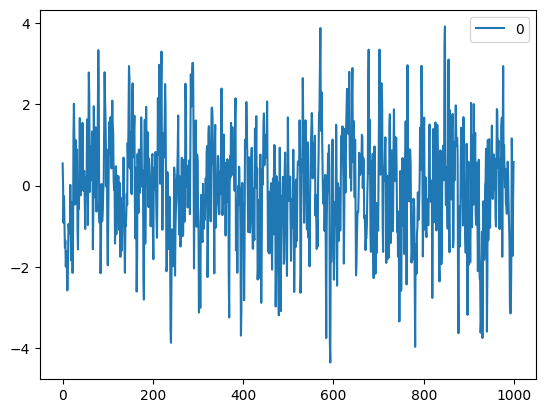

In [322]:
arcoefs = [1] + list(model_fit.params)[1:-1][0:3] #0:p
macoefs = [1] + list(model_fit.params)[1:-1][3:3+2] #p:p+q
armadata = ArmaProcess(arcoefs, macoefs).generate_sample(nsample=1000)
pd.DataFrame(armadata).plot()

In [382]:
pred = model_fit.get_prediction().summary_frame()

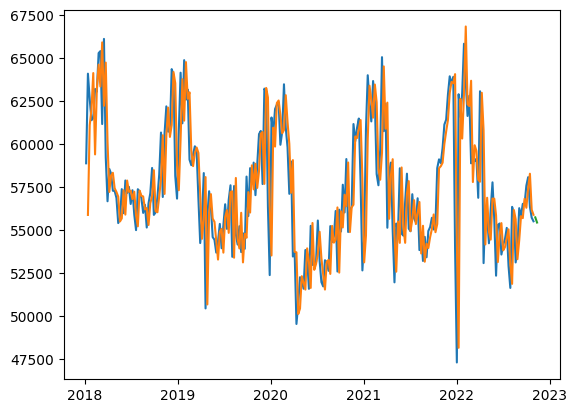

In [386]:
#plot_predict(model_fit)
plt.plot(ens12.index, ens12.data)
plt.plot(pred.iloc[1:].index, pred.iloc[1:]['mean'])
plt.plot(pd.DataFrame(fc).index, pd.DataFrame(fc).predicted_mean)
plt.show()

In [387]:
fc = model_fit.forecast(1) 

In [399]:
float(fc)

55756.67665667059

In [402]:
float(ens12[-5:].describe().loc["std"])

1135.8959899568272

In [18]:
dfs = [enf12, enf16, enf20, ens12, ens16, ens20]
params = pd.DataFrame(columns = ["h1", "h2", "h3", "h4", "h5", "h6"])
for i, df in enumerate(dfs):
    model = ARIMA(df.data, order=(3,1,2))
    model_fit = model.fit()
    fc = float(model_fit.forecast(1))
    params[params.columns[i]] = [fc, float(df[-8:].describe().loc["std"])]

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

In [19]:
params

,h1,h2,h3,h4,h5,h6
0,66178.135717,61432.025059,58253.180134,55764.355727,52266.718233,51752.726034
1,1417.331642,1556.352507,962.355954,881.875345,890.405435,1095.713694


In [20]:
h1sample = np.random.normal(loc=float(params.iloc[0].h1), scale=float(params.iloc[1].h1), size=1000)
h2sample = np.random.normal(loc=float(params.iloc[0].h2), scale=float(params.iloc[1].h2), size=1000)
h3sample = np.random.normal(loc=float(params.iloc[0].h3), scale=float(params.iloc[1].h3), size=1000)
h4sample = np.random.normal(loc=float(params.iloc[0].h4), scale=float(params.iloc[1].h4), size=1000)
h5sample = np.random.normal(loc=float(params.iloc[0].h5), scale=float(params.iloc[1].h5), size=1000)
h6sample = np.random.normal(loc=float(params.iloc[0].h6), scale=float(params.iloc[1].h6), size=1000)

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

h1quantiles = np.quantile(h1sample, quantiles)
h2quantiles = np.quantile(h2sample, quantiles)
h3quantiles = np.quantile(h3sample, quantiles)
h4quantiles = np.quantile(h4sample, quantiles)
h5quantiles = np.quantile(h5sample, quantiles)
h6quantiles = np.quantile(h6sample, quantiles)

energyquantiles = [h1quantiles, h2quantiles, h3quantiles, h4quantiles, h5quantiles, h6quantiles]
energyquantiles = [q/1000 for q in energyquantiles]

# Submission Creation

In [21]:
submission = create_submission_table()

In [22]:
for i in range(5):
    submission.loc[i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = daxquantiles[i]

In [23]:
for i in range(6):
    submission.loc[5+i, ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]] = energyquantiles[i]

In [24]:
submission

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2022-11-09,DAX,1 day,-2.350412,-0.749100,0.019884,0.832245,2.412111
1,2022-11-09,DAX,2 day,-2.208824,-0.783873,-0.016311,0.652461,2.123376
2,2022-11-09,DAX,5 day,-2.288989,-0.731556,0.084455,0.749908,2.224943
3,2022-11-09,DAX,6 day,-2.340303,-0.776950,0.036760,0.766465,2.147962
4,2022-11-09,DAX,7 day,-2.475717,-0.932492,-0.039570,0.869812,2.398690
5,2022-11-09,energy,36 hour,63.334649,65.255982,66.189848,66.991211,68.965381
6,2022-11-09,energy,40 hour,58.421826,60.383051,61.462098,62.327451,64.487681
7,2022-11-09,energy,44 hour,56.409061,57.620520,58.292062,58.905864,60.054276
8,2022-11-09,energy,60 hour,54.045025,55.110471,55.758133,56.369280,57.514202
9,2022-11-09,energy,64 hour,50.542656,51.656059,52.234609,52.834784,54.072485


In [25]:
create_submission_file(submission)

Submission file created


# Check

In [26]:
! python check.py -p 20221109_GreyWorm.csv

{'path': '20221109_GreyWorm.csv', 'exclude_weather': None}
Loading file... 20221109_GreyWorm.csv
File loaded! Start Checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- wind -- is your NaN-target. Please DOUBLECHECK if this is correct.
---------------------------
Looks good!


# Testing

## DAX

Iteration:      1,   Func. Count:     33,   Neg. LLF: 21950.765081436144
Iteration:      2,   Func. Count:     69,   Neg. LLF: 409507.8579172745
Iteration:      3,   Func. Count:    102,   Neg. LLF: 17480.056048645503
Iteration:      4,   Func. Count:    135,   Neg. LLF: 17635.08582321084
Iteration:      5,   Func. Count:    169,   Neg. LLF: 19659.193115605118
Iteration:      6,   Func. Count:    202,   Neg. LLF: 15044.169308397184
Iteration:      7,   Func. Count:    235,   Neg. LLF: 15477.150263145635
Iteration:      8,   Func. Count:    268,   Neg. LLF: 27905.27924522557
Iteration:      9,   Func. Count:    301,   Neg. LLF: 17634.03124417255
Iteration:     10,   Func. Count:    334,   Neg. LLF: 19035.99811852122
Iteration:     11,   Func. Count:    368,   Neg. LLF: 16033.476512568524
Iteration:     12,   Func. Count:    402,   Neg. LLF: 15959.107267944075
Iteration:     13,   Func. Count:    436,   Neg. LLF: 14609.976578481223
Iteration:     14,   Func. Count:    469,   Neg. LLF: 15

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


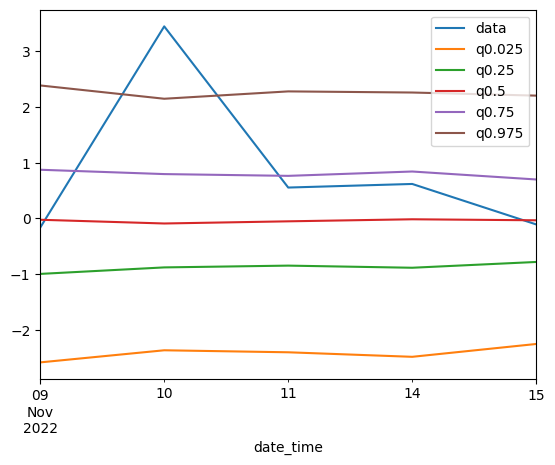

In [96]:
dax_eval(daxdata)

In [16]:
daxdata = get_dax_data()
daxtraindata = daxdata[:-5]
daxtestdata = daxdata[-5:]

In [18]:
daxtestdata.tail(10)

,data
date_time,
2022-11-09 00:00:00+01:00,-0.163989
2022-11-10 00:00:00+01:00,3.450382
2022-11-11 00:00:00+01:00,0.555291
2022-11-14 00:00:00+01:00,0.619800
2022-11-15 00:00:00+01:00,-0.107161


In [19]:
daxforecast = dax_model(daxtraindata)

Iteration:      1,   Func. Count:     33,   Neg. LLF: 21950.765081436144
Iteration:      2,   Func. Count:     69,   Neg. LLF: 409507.8579172745
Iteration:      3,   Func. Count:    102,   Neg. LLF: 17480.056048645503
Iteration:      4,   Func. Count:    135,   Neg. LLF: 17635.08582321084
Iteration:      5,   Func. Count:    169,   Neg. LLF: 19659.193115605118
Iteration:      6,   Func. Count:    202,   Neg. LLF: 15044.169308397184
Iteration:      7,   Func. Count:    235,   Neg. LLF: 15477.150263145635
Iteration:      8,   Func. Count:    268,   Neg. LLF: 27905.27924522557
Iteration:      9,   Func. Count:    301,   Neg. LLF: 17634.03124417255
Iteration:     10,   Func. Count:    334,   Neg. LLF: 19035.99811852122
Iteration:     11,   Func. Count:    368,   Neg. LLF: 16033.476512568524
Iteration:     12,   Func. Count:    402,   Neg. LLF: 15959.107267944075
Iteration:     13,   Func. Count:    436,   Neg. LLF: 14609.976578481223
Iteration:     14,   Func. Count:    469,   Neg. LLF: 15

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [22]:
daxforecast = pd.DataFrame(daxforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

In [72]:
daxforecast["q0.025"]

0   -2.576693
1   -2.218428
2   -2.319296
3   -2.471013
4   -2.399639
Name: q0.025, dtype: float64

In [69]:
daxtestdata

,data
date_time,
2022-11-09 00:00:00+01:00,-0.163989
2022-11-10 00:00:00+01:00,3.450382
2022-11-11 00:00:00+01:00,0.555291
2022-11-14 00:00:00+01:00,0.619800
2022-11-15 00:00:00+01:00,-0.107161


In [75]:
daxevaldata = daxtestdata.copy(deep=True)
daxevaldata["q0.025"] = np.array(daxforecast["q0.025"])
daxevaldata["q0.25"] = np.array(daxforecast["q0.25"])
daxevaldata["q0.5"] = np.array(daxforecast["q0.5"])
daxevaldata["q0.75"] = np.array(daxforecast["q0.75"])
daxevaldata["q0.975"] = np.array(daxforecast["q0.975"])

<AxesSubplot: xlabel='date_time'>

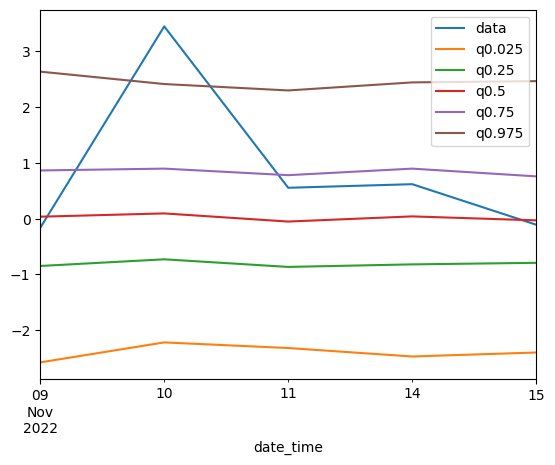

In [77]:
daxevaldata.plot()

In [78]:
totalloss = 0
for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
    for i in range(len(daxevaldata)):
        totalloss += quantile_loss(daxevaldata["data"].iloc[i], daxevaldata[q].iloc[i], float(q[1:]))
totalloss

8.664021371664832

## Energy

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

*********************************
Quantile Loss: 133.37511676913212
*********************************


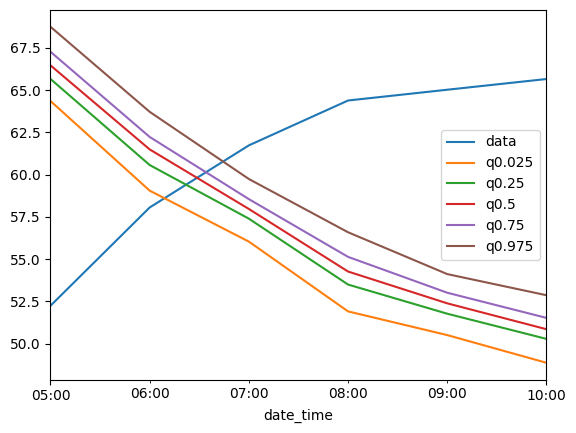

In [93]:
energy_eval(energydata)

In [79]:
energydata = get_energy_data()
energytraindata = energydata[:-6]
energytestdata = energydata[-6:]

In [80]:
energyforecast = energy_model(energytraindata)

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

In [81]:
energyforecast = pd.DataFrame(energyforecast, columns = ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"])

In [82]:
energyevaldata = energytestdata.copy(deep=True)
energyevaldata["q0.025"] = np.array(energyforecast["q0.025"])
energyevaldata["q0.25"] = np.array(energyforecast["q0.25"])
energyevaldata["q0.5"] = np.array(energyforecast["q0.5"])
energyevaldata["q0.75"] = np.array(energyforecast["q0.75"])
energyevaldata["q0.975"] = np.array(energyforecast["q0.975"])

In [86]:
energyevaldata.data = energyevaldata.data / 1000

In [88]:
energyevaldata

,data,q0.025,q0.25,q0.5,q0.75,q0.975
date_time,,,,,,
2022-11-15 05:00:00,52.239,64.411065,65.763833,66.487825,67.221188,68.553371
2022-11-15 06:00:00,58.053,58.939526,60.706516,61.508696,62.367468,63.826340
2022-11-15 07:00:00,61.729,56.009735,57.305902,57.941449,58.570340,59.706431
2022-11-15 08:00:00,64.384,52.112073,53.583775,54.366784,55.236720,56.618414
2022-11-15 09:00:00,65.021,50.660210,51.737224,52.346646,52.924362,54.160961
2022-11-15 10:00:00,65.655,48.976598,50.265454,50.815393,51.534883,52.761449


<AxesSubplot: xlabel='date_time'>

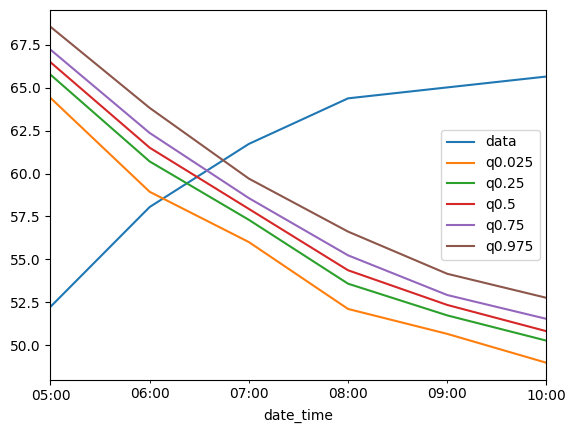

In [87]:
energyevaldata.plot()

In [89]:
totalloss = 0
for q in ["q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]:
    for i in range(len(energyevaldata)):
        totalloss += quantile_loss(energyevaldata["data"].iloc[i], energyevaldata[q].iloc[i], float(q[1:]))
totalloss

133.54901219201034